In [1]:
import json
import pandas as pd
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders
import matplotlib.pyplot as plt


In [2]:
def get_journals_from_OpenAlex(path_openalex, source_type):
    """ Extracting journals that are citing a proceeding document 

    Extracts the corresponding journals names and their OpenAlex IDs, that are citing document with ID.
    
    Args:
        path_openalex (str): Path to the Json File including the citing documents
        source_type (str): Allows to select between Journal and Conference sources

    Returns:
        df_OA: Dataframe including the document ID and the corresponding journals 

    """
    # Readin the json file with the citing documents
    with open(path_openalex, 'r', encoding="utf-8") as file:
        OpenAlexCitations = json.load(file)

    journals_open_alex = []
    for i in OpenAlexCitations:
        list_journals = []
        for j in OpenAlexCitations[i]:
            if j.get("primary_location") and j["primary_location"].get("source") and j["primary_location"]["source"].get("type") == source_type:
                try:
                    # Adding the journal names and ids 
                    list_journals.append([j["primary_location"]["source"]["display_name"], j["primary_location"]["source"]["id"]])
                except:
                    continue
        journals_open_alex.append([i, list_journals])

    # Creating the dataframe including the ID and the corresponding journals
    df_OA = pd.DataFrame(journals_open_alex, columns=["ID", "Journals"])
    
    return df_OA

In [3]:
# Creating the dataframes with the citing journals for all three proceedings

df_ceur_journals = get_journals_from_OpenAlex("../../../data/OpenAlex_CEUR_citing_doc.json", source_type="journal")
df_lncs_journals = get_journals_from_OpenAlex("../../../data/OpenAlex_LNCS_citing_doc.json", source_type="journal")
df_trec_journals = get_journals_from_OpenAlex("../../../data/OpenAlex_TREC_citing_doc.json", source_type="journal")

In [4]:
df_ceur_journals

,ID,Journals
0,ceur_1038,[]
1,ceur_1068,[]
2,ceur_1069,"[[CLEF (Working Notes), https://openalex.org/S..."
3,ceur_1130,[]
4,ceur_1568,[[IEEE journal of selected topics in applied e...
...,...,...
2853,ceur_3250,[]
2854,ceur_3302,[]
2855,ceur_3303,[]
2856,ceur_3304,"[[Computer Science and Information Systems, ht..."


In [5]:
lookup_list = []
for i, j in df_ceur_journals.iterrows():
    for k in j["Journals"]:
        if k not in lookup_list:
            lookup_list.append(k)

In [6]:
for i, j in df_lncs_journals.iterrows():
    for k in j["Journals"]:
        if k not in lookup_list:
            lookup_list.append(k)

In [7]:
for i, j in df_trec_journals.iterrows():
    for k in j["Journals"]:
        if k not in lookup_list:
            lookup_list.append(k)

In [8]:
for i in lookup_list:
    impact_factor = Sources()[i[1].replace("https://openalex.org/", "")]["summary_stats"]["2yr_mean_citedness"]
    i.append(impact_factor)

In [11]:
def collect_impact_factors(nested_list):
    impact_factors = []
    for item in nested_list:
        for lookup_item in lookup_list:
            if item[0] == lookup_item[0] and item[1] == lookup_item[1]:
                impact_factors.append(lookup_item[2])
    return impact_factors if impact_factors else None

In [12]:
df_ceur_journals['impact_factor'] = df_ceur_journals['Journals'].apply(collect_impact_factors)
df_trec_journals['impact_factor'] = df_trec_journals['Journals'].apply(collect_impact_factors)
df_lncs_journals['impact_factor'] = df_lncs_journals['Journals'].apply(collect_impact_factors)

In [13]:
df_ceur_journals.iloc[2]["impact_factor"]

[0.3924731182795699, 5.317782805429864]

In [14]:
def calculate_mean(impact_factors):
    if impact_factors:
        return sum(impact_factors) / len(impact_factors)
    return None

# Calculate the average impact factor of all citing journal papers
df_ceur_journals['mean_impact_factor'] = df_ceur_journals['impact_factor'].apply(calculate_mean)
df_trec_journals['mean_impact_factor'] = df_trec_journals['impact_factor'].apply(calculate_mean)
df_lncs_journals['mean_impact_factor'] = df_lncs_journals['impact_factor'].apply(calculate_mean)

In [15]:
df_ceur_journals

,ID,Journals,impact_factor,mean_impact_factor
0,ceur_1038,[],None,NaN
1,ceur_1068,[],None,NaN
2,ceur_1069,"[[CLEF (Working Notes), https://openalex.org/S...","[0.3924731182795699, 5.317782805429864]",2.855128
3,ceur_1130,[],None,NaN
4,ceur_1568,[[IEEE journal of selected topics in applied e...,"[5.602473498233215, 9.723702664796633, 8.70123...",3.910665
...,...,...,...,...
2853,ceur_3250,[],None,NaN
2854,ceur_3302,[],None,NaN
2855,ceur_3303,[],None,NaN
2856,ceur_3304,"[[Computer Science and Information Systems, ht...",[1.5394736842105263],1.539474


In [16]:
def add_OpenAlexCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        OpenAlexCitations = json.load(file)
    
    citations_OpenAlex = []
    for i in OpenAlexCitations:
        try:
            citations_OpenAlex.append([i, OpenAlexCitations[i]["cited_by_count"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_OpenAlex, columns=["ID", "Citations_OpenAlex"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [17]:
df_lncs_journals = add_OpenAlexCitations(df_lncs_journals, "../../../data/OpenAlex_LNCS.json")
df_trec_journals = add_OpenAlexCitations(df_trec_journals, "../../../data/OpenAlex_TREC.json")
df_ceur_journals = add_OpenAlexCitations(df_ceur_journals, "../../../data/OpenAlex_CEUR.json")

In [18]:
df_ceur_journals

,ID,Journals,impact_factor,mean_impact_factor,Citations_OpenAlex
0,ceur_1038,[],None,NaN,0
1,ceur_1068,[],None,NaN,0
2,ceur_1069,"[[CLEF (Working Notes), https://openalex.org/S...","[0.3924731182795699, 5.317782805429864]",2.855128,2
3,ceur_1130,[],None,NaN,1
4,ceur_1568,[[IEEE journal of selected topics in applied e...,"[5.602473498233215, 9.723702664796633, 8.70123...",3.910665,27
...,...,...,...,...,...
2853,ceur_3250,[],None,NaN,0
2854,ceur_3302,[],None,NaN,0
2855,ceur_3303,[],None,NaN,0
2856,ceur_3304,"[[Computer Science and Information Systems, ht...",[1.5394736842105263],1.539474,1


In [19]:
df_ceur_journals = df_ceur_journals.dropna(subset=['mean_impact_factor'])
df_trec_journals = df_trec_journals.dropna(subset=['mean_impact_factor'])
df_lncs_journals = df_lncs_journals.dropna(subset=['mean_impact_factor'])

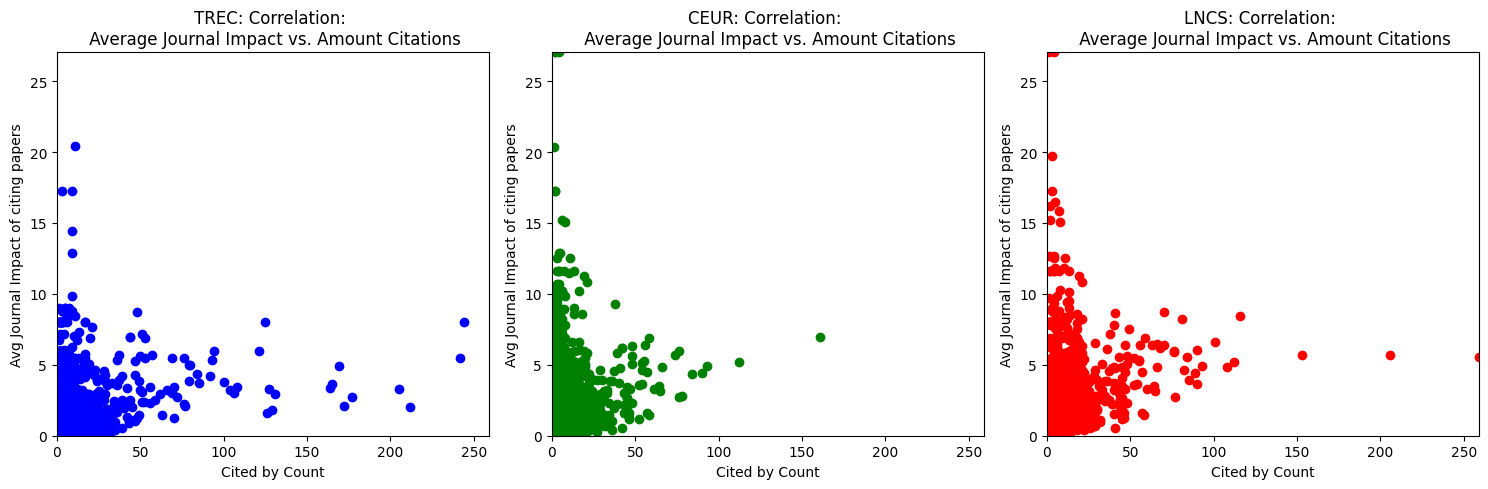

In [20]:
# Determine the minimum and maximum values for axis limits across all DataFrames
min_citations = min(df_trec_journals['Citations_OpenAlex'].min(), df_ceur_journals['Citations_OpenAlex'].min(), df_lncs_journals['Citations_OpenAlex'].min())
max_citations = max(df_trec_journals['Citations_OpenAlex'].max(), df_ceur_journals['Citations_OpenAlex'].max(), df_lncs_journals['Citations_OpenAlex'].max())

min_hindex = min(df_trec_journals['mean_impact_factor'].min(), df_ceur_journals['mean_impact_factor'].min(), df_lncs_journals['mean_impact_factor'].min())
max_hindex = max(df_trec_journals['mean_impact_factor'].max(), df_ceur_journals['mean_impact_factor'].max(), df_lncs_journals['mean_impact_factor'].max())

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df_trec_journals['Citations_OpenAlex'], df_trec_journals['mean_impact_factor'], color='blue')
axs[0].set_title('TREC: Correlation: \n Average Journal Impact vs. Amount Citations')
axs[0].set_xlabel('Cited by Count')
axs[0].set_ylabel('Avg Journal Impact of citing papers')
# Set consistent x and y axis limits for all plots
axs[0].set_xlim(min_citations, max_citations)
axs[0].set_ylim(min_hindex, max_hindex)

axs[1].scatter(df_ceur_journals['Citations_OpenAlex'], df_ceur_journals['mean_impact_factor'], color='green')
axs[1].set_title('CEUR: Correlation: \n Average Journal Impact vs. Amount Citations')
axs[1].set_xlabel('Cited by Count')
axs[1].set_ylabel('Avg Journal Impact of citing papers')
axs[1].set_xlim(min_citations, max_citations)
axs[1].set_ylim(min_hindex, max_hindex)

axs[2].scatter(df_lncs_journals['Citations_OpenAlex'], df_lncs_journals['mean_impact_factor'], color='red')
axs[2].set_title('LNCS: Correlation: \n Average Journal Impact vs. Amount Citations')
axs[2].set_xlabel('Cited by Count')
axs[2].set_ylabel('Avg Journal Impact of citing papers')
axs[2].set_xlim(min_citations, max_citations)
axs[2].set_ylim(min_hindex, max_hindex)

plt.tight_layout()
plt.savefig('../../../images/correlation_journal_impact_citations.png', dpi=300)  
plt.show()

In [21]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_trec_journals["Citations_OpenAlex"], df_trec_journals["mean_impact_factor"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.14988367710513334
P-Wert: 8.023457710476533e-05


In [22]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_ceur_journals["Citations_OpenAlex"], df_ceur_journals["mean_impact_factor"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.13562097942504653
P-Wert: 1.6774991121890216e-07


In [23]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_lncs_journals["Citations_OpenAlex"], df_lncs_journals["mean_impact_factor"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.11917705779437167
P-Wert: 0.0004791714908761661
